Importing Lirary 

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.figsize':(12,8), 'figure.dpi':120})

In [33]:
df=pd.read_csv('AirPassengers.csv')
df

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [35]:
df['Month'] = pd.to_datetime(df['Month'])

In [37]:
df.set_index('Month', inplace=True)

In [39]:
df.index.min()
df.index.max()

Timestamp('1960-12-01 00:00:00')

In [41]:
df.isnull().sum()

#Passengers    0
dtype: int64

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [45]:
df.columns


Index(['#Passengers'], dtype='object')

In [46]:
df.rename(columns={'#Passengers':'Passengers'}, inplace=True)

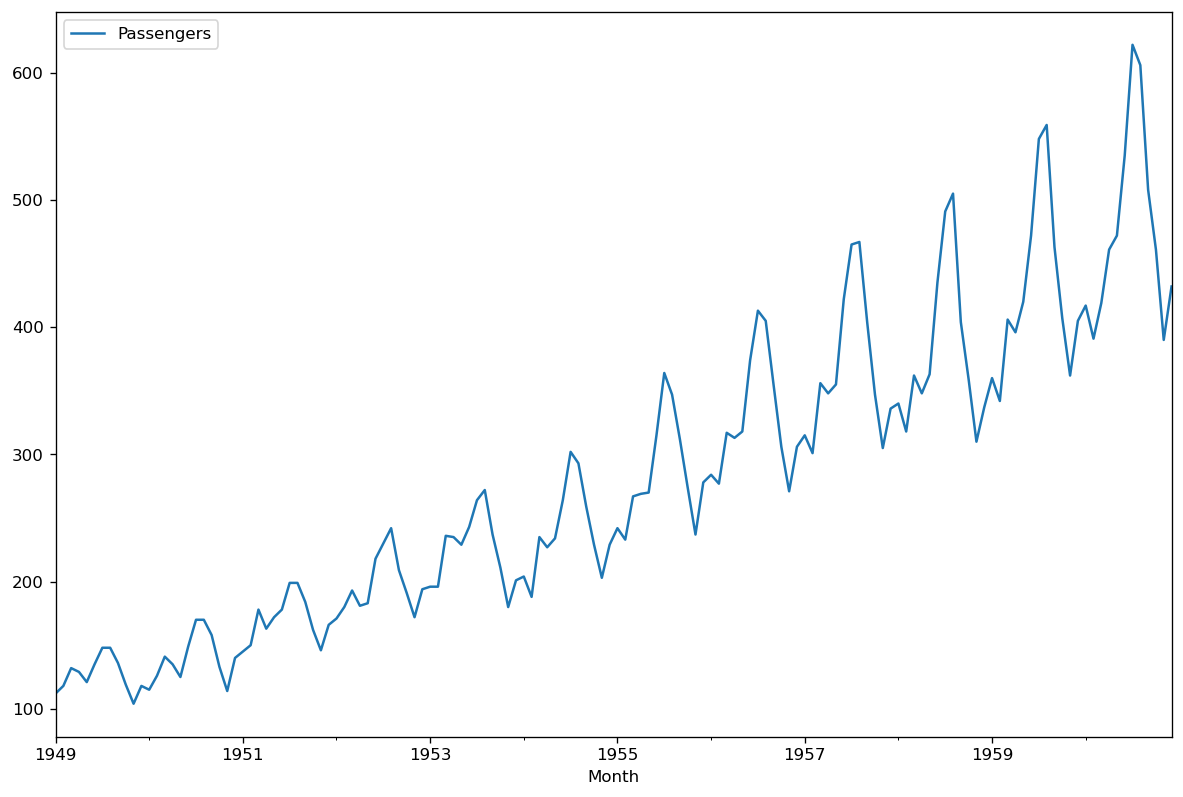

In [47]:
df.plot()
plt.show()

as shows this is a seasonal data 

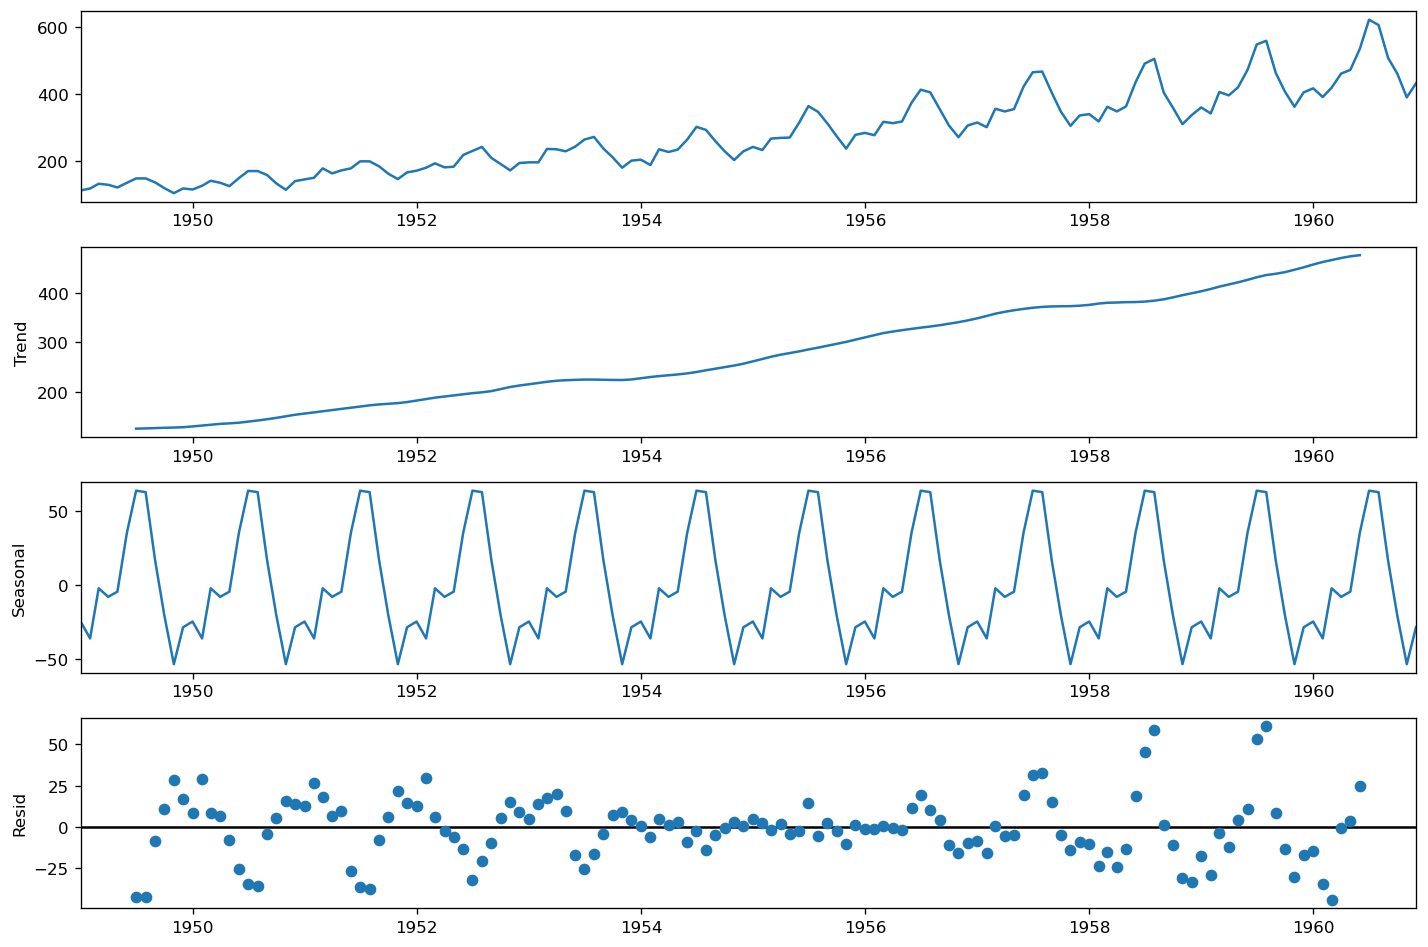

In [48]:

df_decompose=sm.tsa.seasonal_decompose(df,model='additive', period=12)
df_decompose.plot()
plt.show()

ugmented Dickey-Fuller (ADF) Test or Unit Root Test
The ADF test is the most popular statistical test. It is done with the following assumptions:

Null Hypothesis (H0): Series is non-stationary
Alternate Hypothesis (HA): Series is stationary
p-value >0.05 Fail to reject (H0)
p-value <= 0.05 Accept (H1)

In [49]:

from statsmodels.tsa.stattools import adfuller
#P-VALUE  >0.05----->NOT Stationary
#P-VALUE  <=0.05-----> Stationary
result=adfuller(df['Passengers'])
print('p-value: %f' % result[1])
print('ADF Statistic:', result[0])
print('Critical Values:', result[4])

if result[1]>0.05:
  print('NON Stationary')
else:
  print('Stationary')

p-value: 0.991880
ADF Statistic: 0.8153688792060463
Critical Values: {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}
NON Stationary


In [50]:
len(df)

144

In [51]:
train=df[:115]
test=df[115:]

In [52]:
import itertools

In [53]:
p_values=range(0,8)
q_values=range(0,8)
d_values=range(0,2)

In [54]:
pdq_combination = list(itertools.product(p_values,q_values,d_values))

In [55]:
len(pdq_combination)

128

In [59]:
rmse=[]
order1=[]

In [57]:
from sklearn.metrics import mean_squared_error
# Iterate over all possible (p,d,q) combinations
for p in p_values:
    for d in d_values:
        for q in q_values:
            pdq = (p, d, q)
            try:
                # Fit ARIMA model and generate predictions
                model = sm.tsa.arima.ARIMA(train, order=pdq).fit()
                pred = model.predict(start=len(train), end=(len(df)-1))

                # Calculate RMSE and store results
                error = np.sqrt(mean_squared_error(test, pred))
                order1.append(pdq)
                rmse.append(error)
            except:
                # Skip if model fails to converge
                continue

# Find the (p,d,q) order with the lowest RMSE
min_idx = np.argmin(rmse)
best_order = order1[min_idx]
best_rmse = rmse[min_idx]

print(f'Best (p,d,q) order: {best_order}')
print(f'RMSE: {best_rmse}')


Best (p,d,q) order: (7, 0, 7)
RMSE: 64.6350300219912


In [60]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Generate all possible combinations of (p,d,q) and (P,D,Q,s) values
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Initialize variables
orders = []
rmse = []



In [61]:
# Loop through all parameter combinations
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            # Fit SARIMA model
            model = SARIMAX(df, order=param, seasonal_order=param_seasonal)
            results = model.fit()
            
            # Make predictions
            pred = results.predict(start=len(df)-24, end=len(df)-1, dynamic=False)
            test = df['Passengers'][-24:]
            
            # Calculate RMSE
            error = mean_squared_error(test, pred, squared=False)
            
            # Append results to lists
            orders.append((param, param_seasonal))
            rmse.append(error)
        except:
            continue


In [62]:

# Find best parameter combination
min_rmse_index = rmse.index(min(rmse))
best_order = orders[min_rmse_index]

# Print results
print("Best (p,d,q) values: ", best_order[0])
print("Best (P,D,Q,s) values: ", best_order[1])
print("Best RMSE: ", min(rmse))


Best (p,d,q) values:  (2, 1, 2)
Best (P,D,Q,s) values:  (1, 2, 2, 12)
Best RMSE:  14.002721279540316


In [64]:
model=sm.tsa.arima.ARIMA(train, order=(7,1,7)).fit()

In [65]:
pred = model.predict(start=len(train), end=(len(df)-1))

<AxesSubplot:xlabel='Month'>

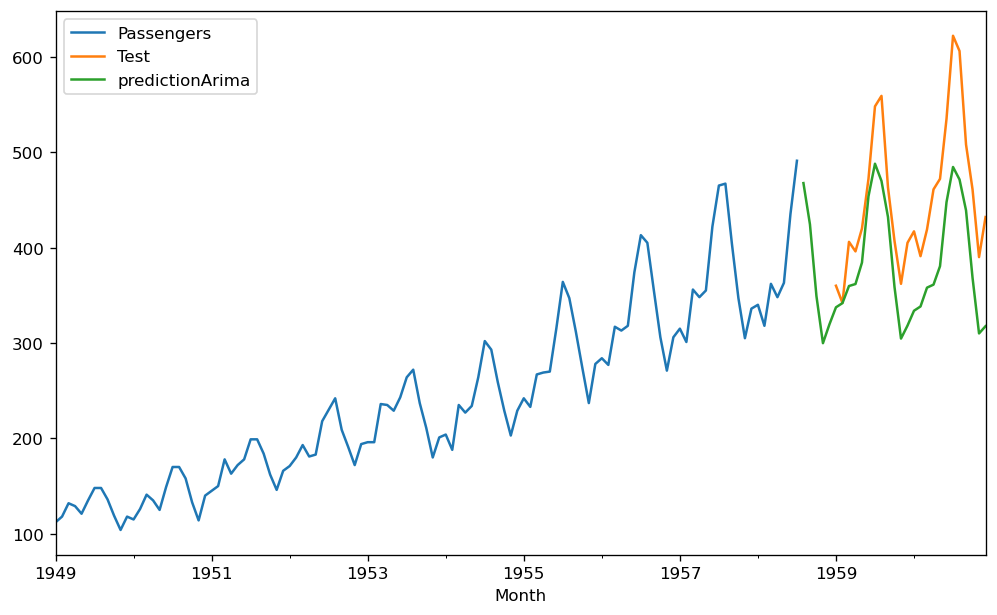

In [66]:
train.plot(legend=True, label='Train',figsize=(10,6))
test.plot(legend=True, label='Test')
pred.plot(legend=True, label='predictionArima')

In [67]:
final_model=sm.tsa.arima.ARIMA(df, order=(7,1,7)).fit()

In [68]:
prediction =final_model.predict(len(df), len(df)+24)

<AxesSubplot:xlabel='Month'>

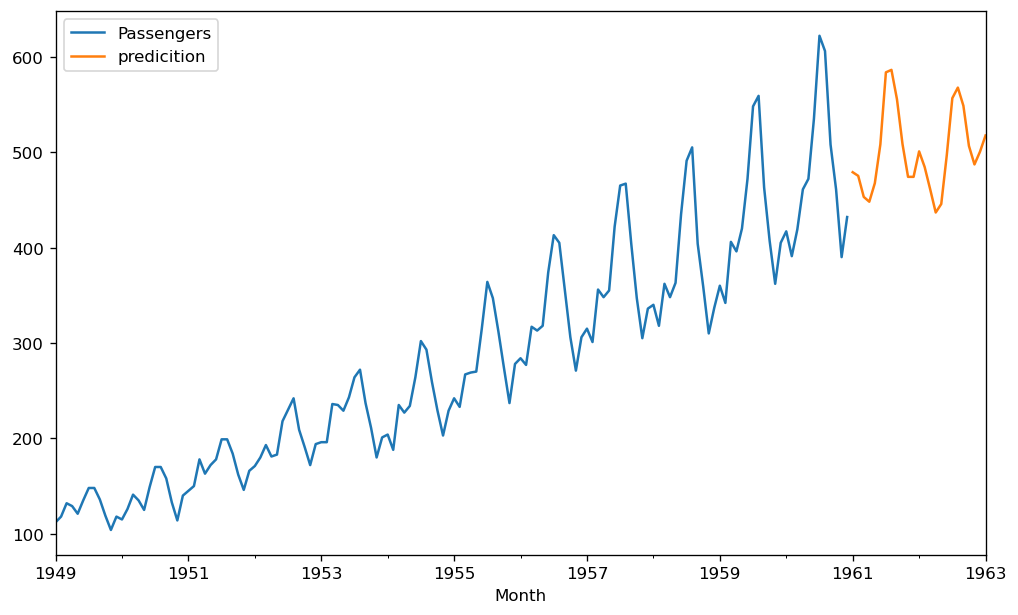

In [69]:
df.plot(legend=True, label='Train',figsize=(10,6))
prediction.plot(legend=True, label='predicition')

In [70]:
model_SARIMAX = SARIMAX(train, order=(2, 1, 2), seasonal_order=(1, 2, 2, 12)).fit()

In [71]:
#model_fit = model_SARIMAX.fit()

In [72]:
predictions = model_SARIMAX.forecast(len(test))

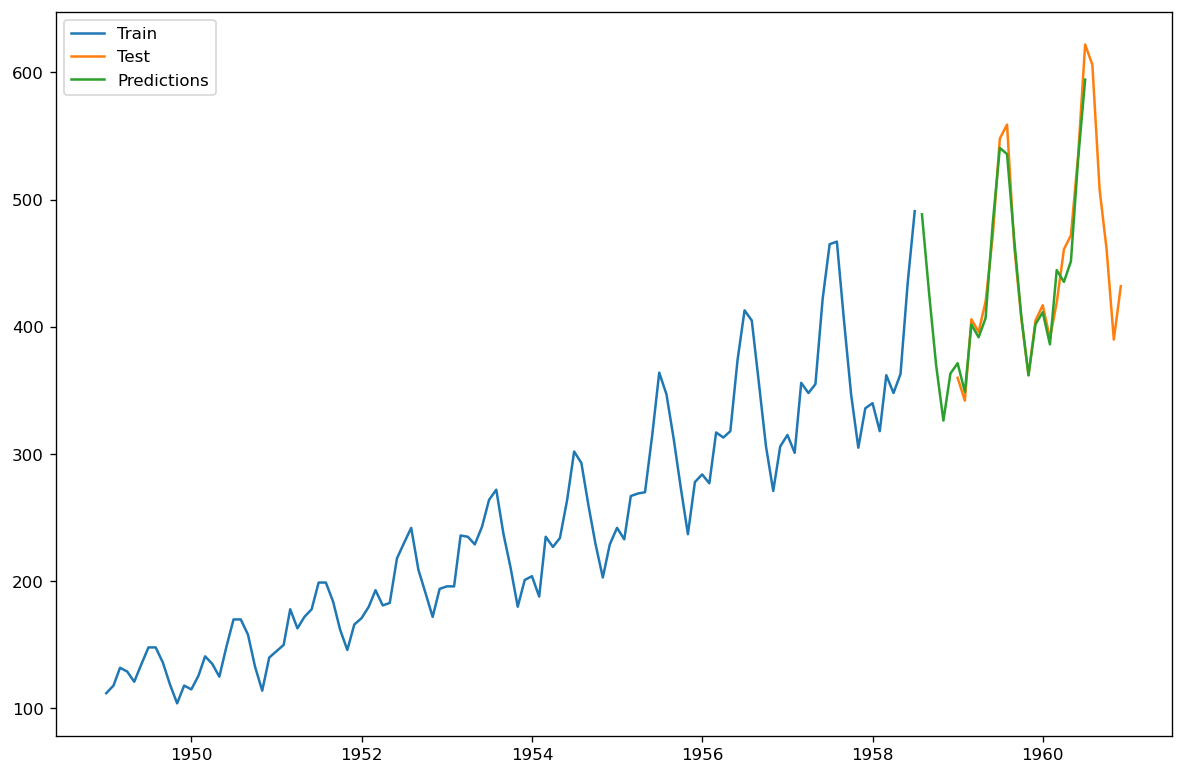

In [73]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(predictions, label='Predictions')
plt.legend()
plt.show()

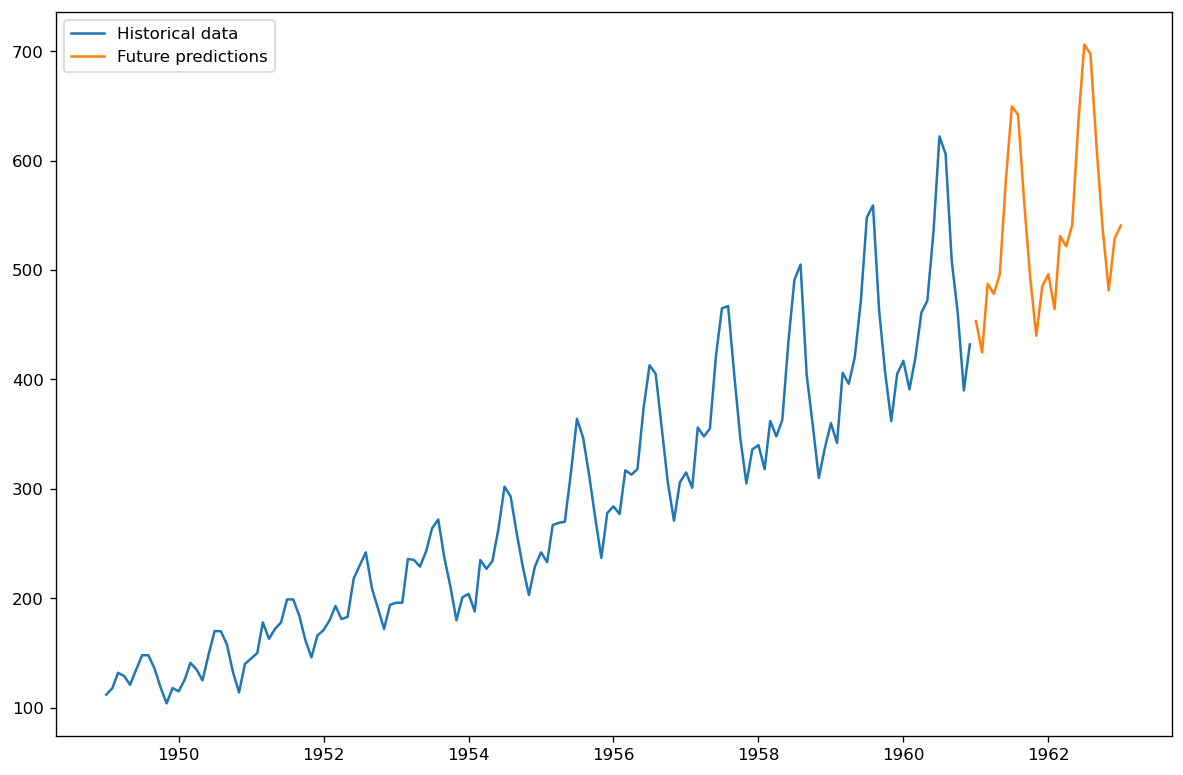

In [74]:
final_model1 = SARIMAX(train, order=(2, 1, 2), seasonal_order=(1, 2, 2, 12)).fit()
future_predictions = final_model1.predict(len(df), len(df)+24)
plt.plot(df, label='Historical data')
plt.plot(future_predictions, label='Future predictions')
plt.legend()
plt.show()

In [90]:
import pickle
pickle.dump(df,open('df.pkl','wb'))
pickle.dump(model_SARIMAX,open('pipe.pkl','wb'))


In [89]:
with open('data.pkl', 'wb') as f:
    pickle.dump(model_SARIMAX, f, protocol=5)

In [77]:
#print(df.index)

In [84]:
import gzip
import pickle

with gzip.open('pipe.pkl.gz', 'wb') as f:
    pickle.dump(model_SARIMAX, f)